Device: cuda


/tmp/ipykernel_3918108/3475051588.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)
/hpc/group/naderilab/eb408/peft_proteomics/peft_proteomics_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 180, 360])) that is different to the input size (torch.Size([4, 1, 1, 180, 360])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/hpc/group/naderilab/eb408/peft_proteomics/peft_proteomics_env/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size

Epoch 1/20, Loss: 76.2537


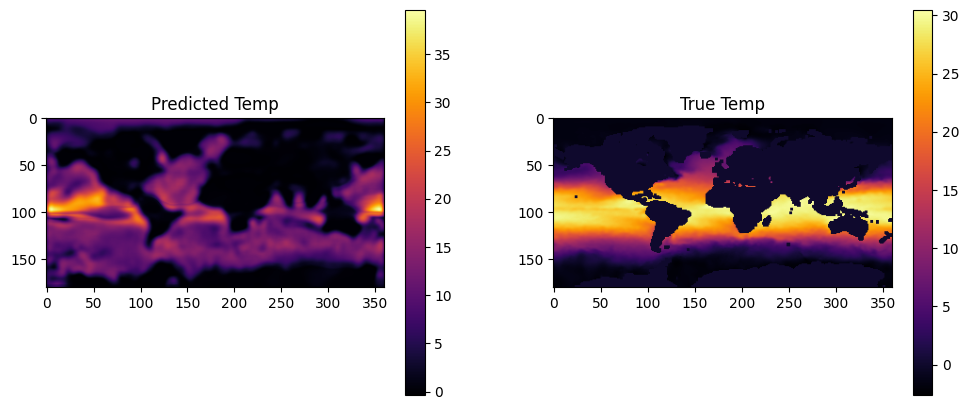

Epoch 2/20, Loss: 47.9506


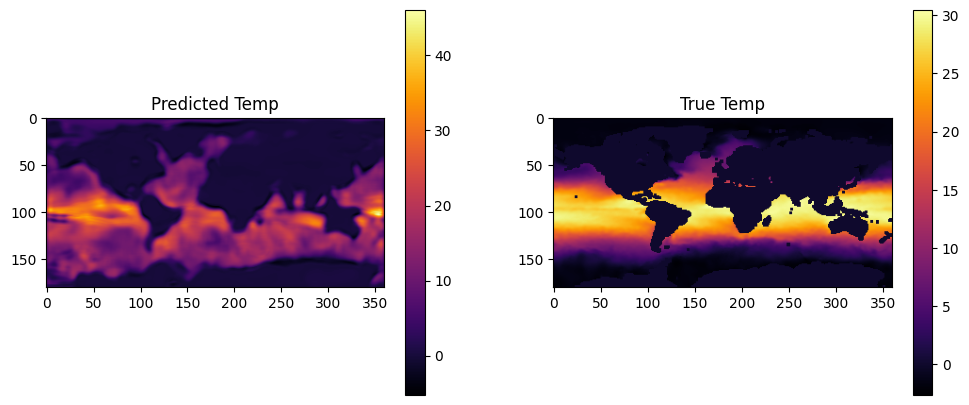

Epoch 3/20, Loss: 34.6083


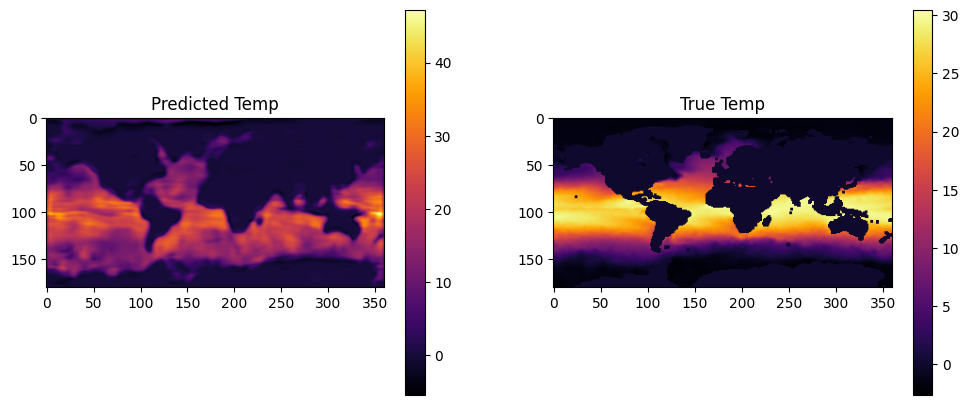

Epoch 4/20, Loss: 27.1571


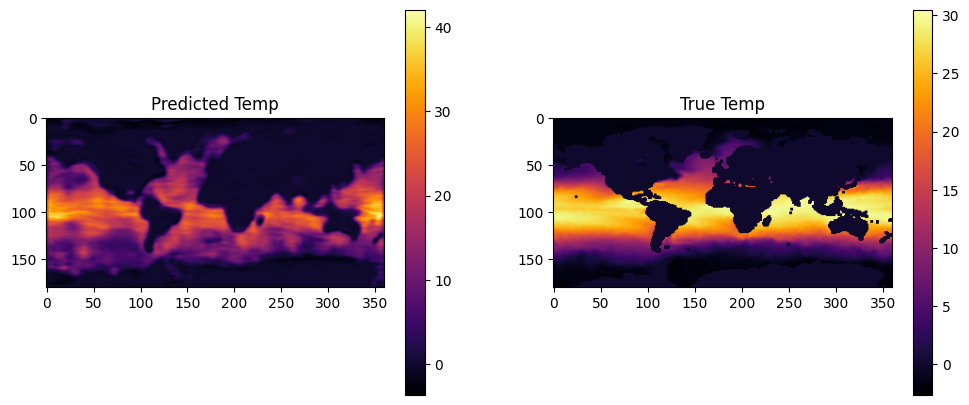

Epoch 5/20, Loss: 22.9722


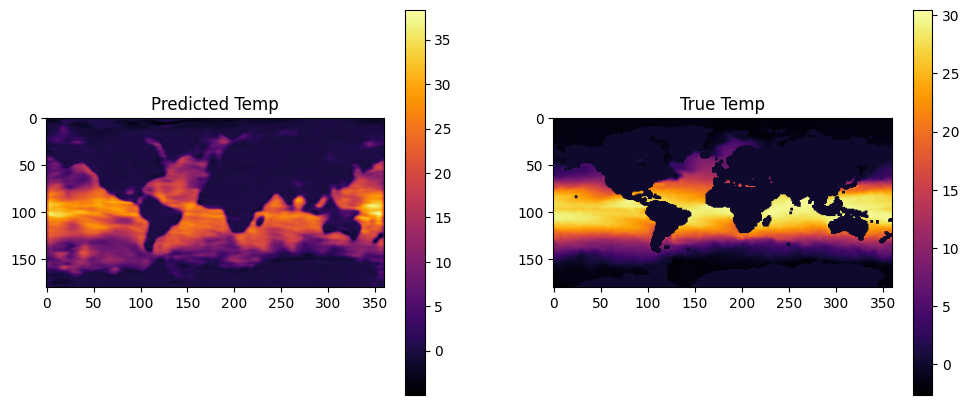

Epoch 6/20, Loss: 19.5806


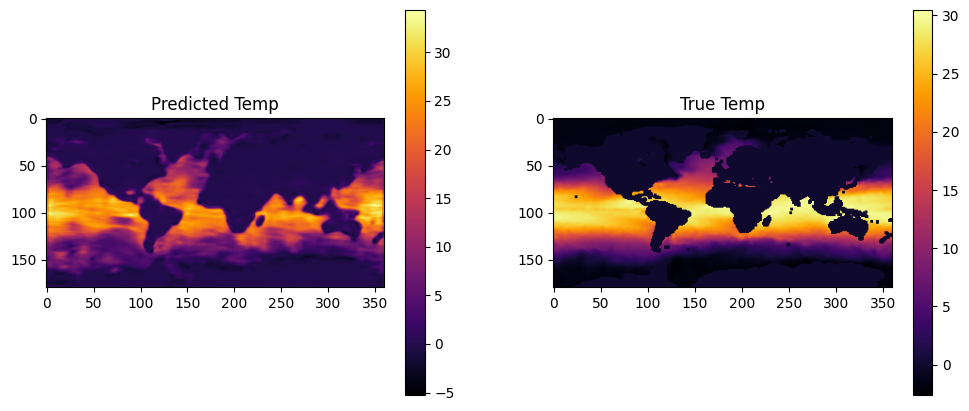

Epoch 7/20, Loss: 17.7303


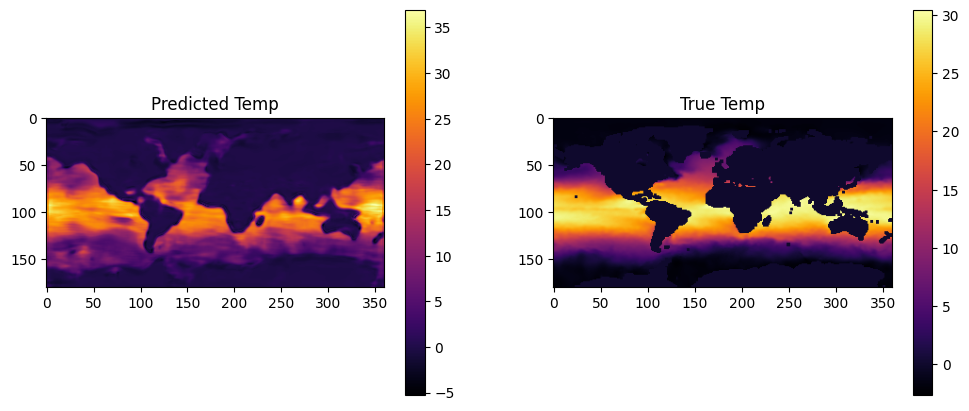

Epoch 8/20, Loss: 15.7971


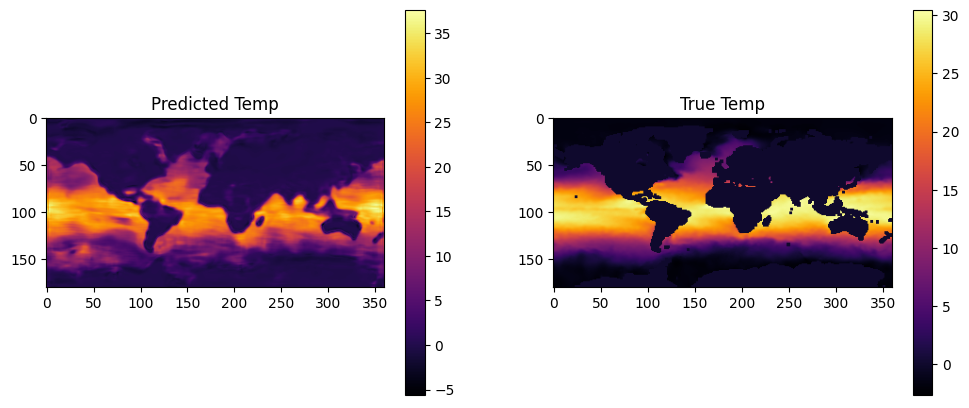

Epoch 9/20, Loss: 14.6902


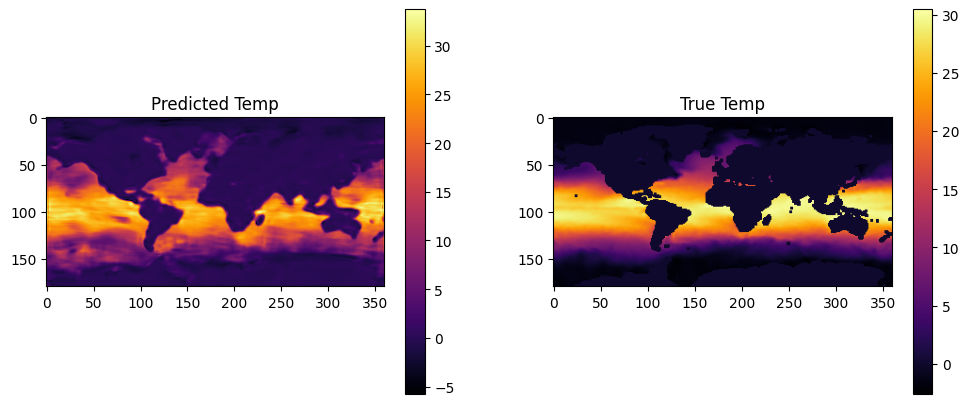

Epoch 10/20, Loss: 13.9520


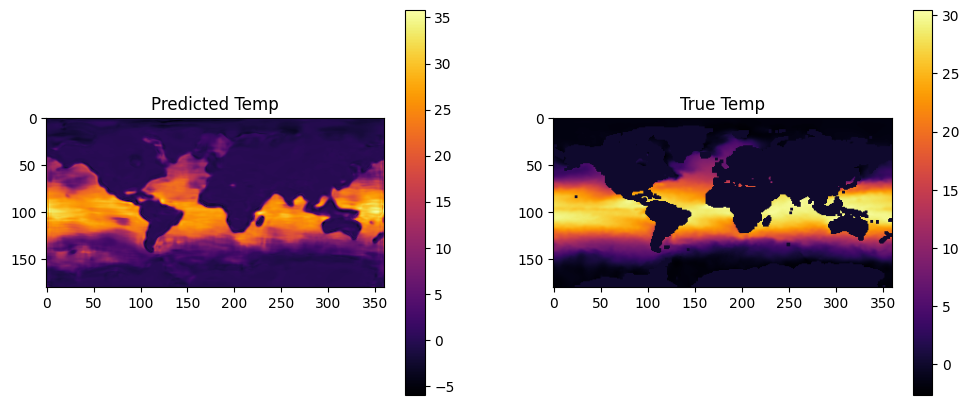

Epoch 11/20, Loss: 12.5637


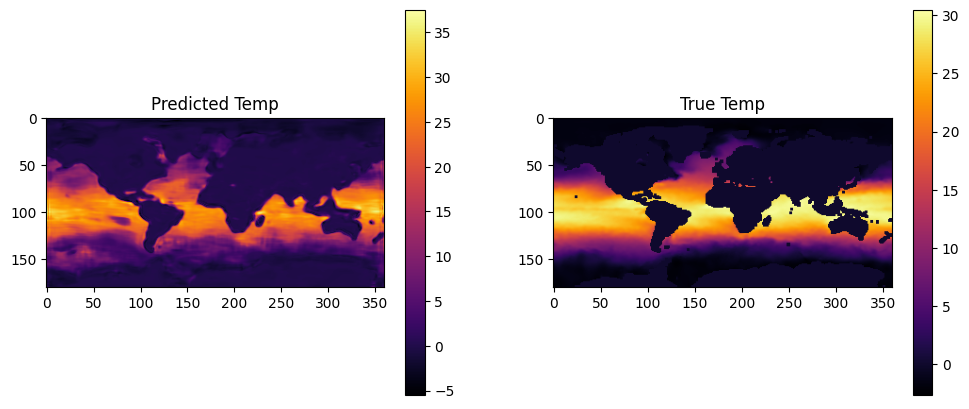

Epoch 12/20, Loss: 12.1665


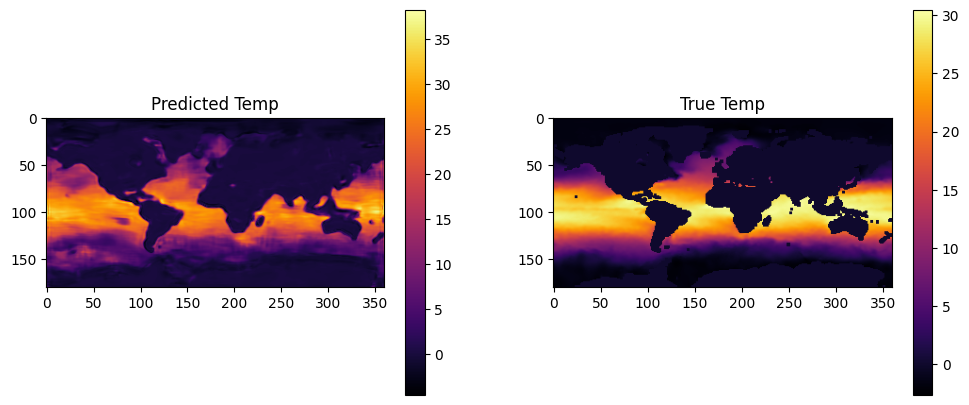

Epoch 13/20, Loss: 11.5739


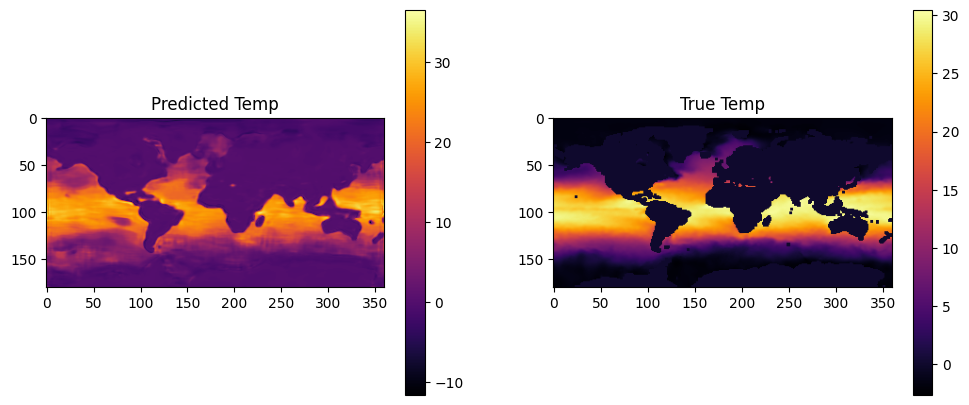

Epoch 14/20, Loss: 10.9446


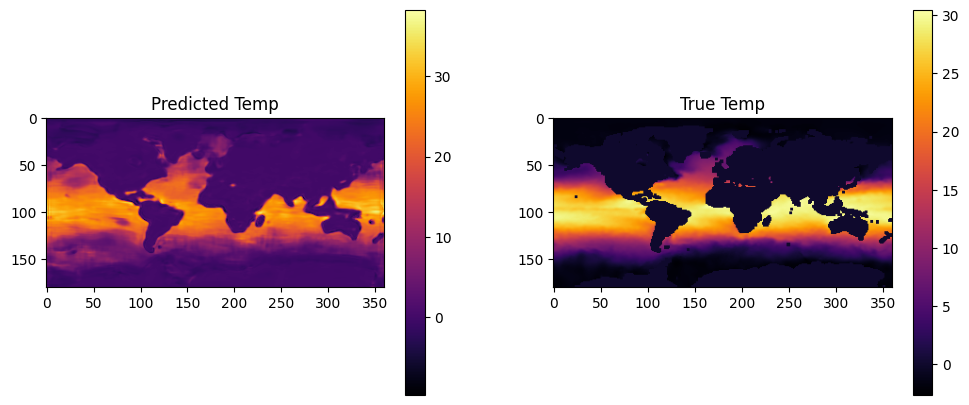

Epoch 15/20, Loss: 10.1646


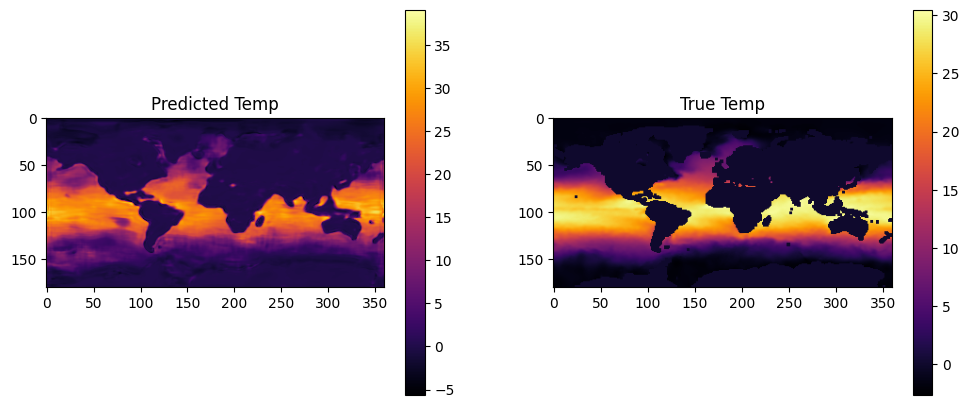

Epoch 16/20, Loss: 9.8644


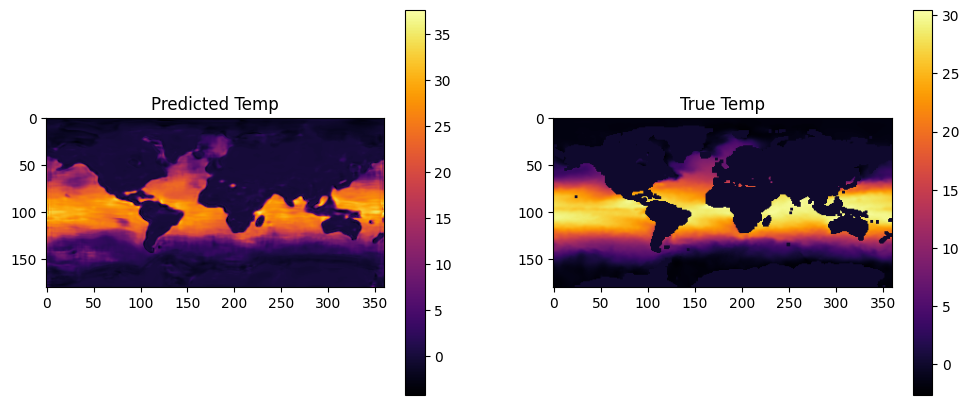

Epoch 17/20, Loss: 9.8781


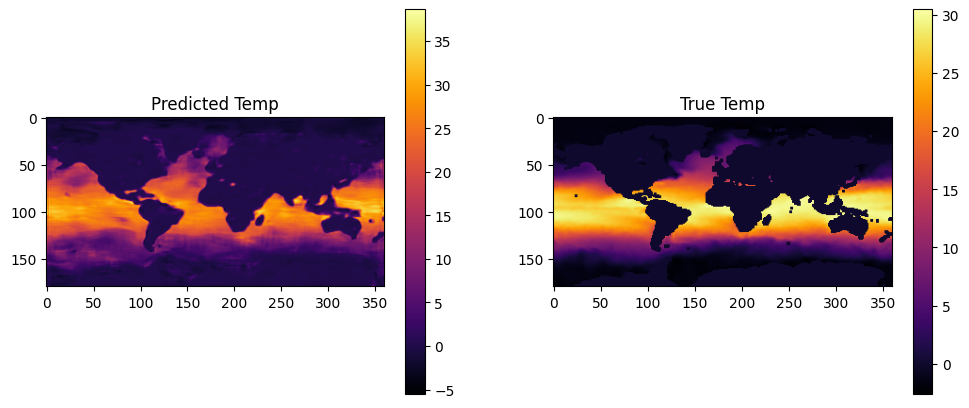

Epoch 18/20, Loss: 9.4590


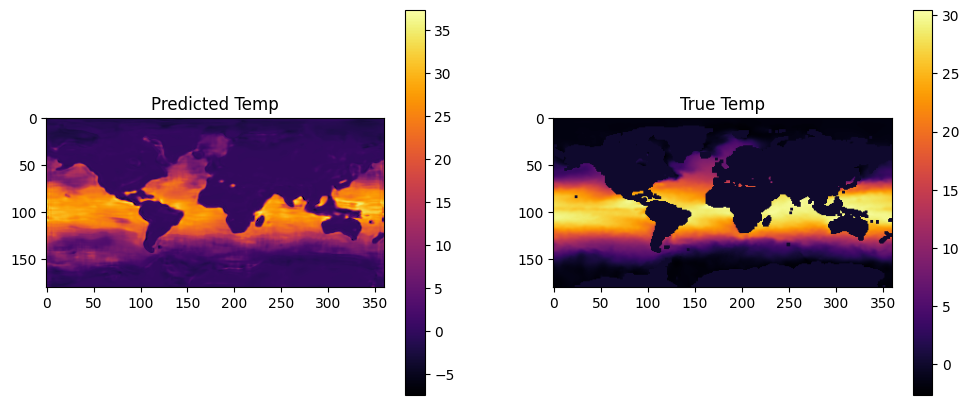

Epoch 19/20, Loss: 9.0678


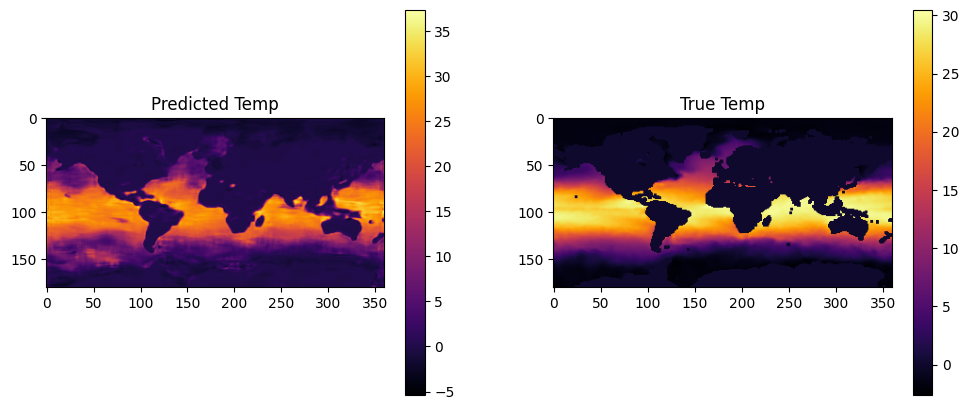

Epoch 20/20, Loss: 8.8804


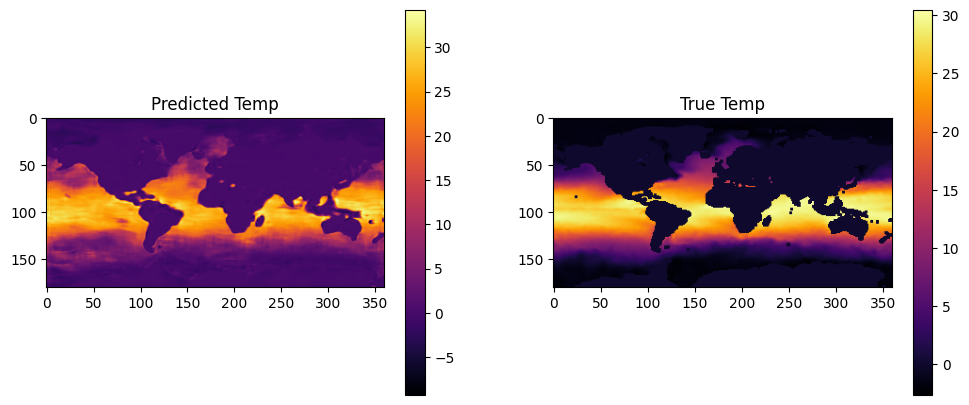

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Data Preprocessing ============
sequence_len = 3

class OceanDataset(Dataset):
    def __init__(self, file_paths, sequence_length=sequence_len):
        self.sequence_length = sequence_length
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        SSH = read_var(file_paths['SSH'], 'SSH')
        SST = read_var(file_paths['SST'], 'SST')
        uSSW = read_var(file_paths['uSSW'], 'uSSW')
        vSSW = read_var(file_paths['vSSW'], 'vSSW')
        ST = read_var(file_paths['depth1'], 'ST')

        from skimage.transform import resize
        SSH = resize(SSH, (SSH.shape[0], 180, 360), preserve_range=True)
        SST = resize(SST, (SST.shape[0], 180, 360), preserve_range=True)
        uSSW = resize(uSSW, (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW = resize(vSSW, (vSSW.shape[0], 180, 360), preserve_range=True)
        ST = resize(ST, (ST.shape[0], 180, 360), preserve_range=True)

        X = np.stack([SSH, SST, uSSW, vSSW], axis=1)
        y = ST

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i-self.sequence_length:i])
            targets.append(y[i])

        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ ConvLSTM Model ============
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)
        self.hidden_dim = hidden_dim
        self.elu = nn.ELU()

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = self.elu(cc_g)
        c = f * c_prev + i * g
        h = o * self.elu(c)
        return h, c

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cells = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, kernel_size) for i in range(num_layers)
        ])
        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        B, T, C, H, W = x.size()
        h = [torch.zeros(B, self.hidden_dim, H, W).to(x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_dim, H, W).to(x.device) for _ in range(self.num_layers)]

        for t in range(T):
            inp = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(inp, h[i], c[i])
                inp = h[i]

        return self.conv_out(h[-1]).unsqueeze(1)


# ============ Training Loop ============
def train_model(model, train_loader, test_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                preds = model(inputs)
                break

        pred_img = preds[0, 0].cpu().numpy()
        true_img = targets[0, 0].cpu().numpy()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.flipud(pred_img.squeeze()), cmap='inferno')
        plt.title("Predicted Temp")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.imshow(np.flipud(true_img.squeeze()), cmap='inferno')
        plt.title("True Temp")
        plt.colorbar()
        plt.show()

# ============ Run ============
file_paths = {
    'SSH': 'project_SSH_1992-2021.nc',
    'SST': 'project_SST_1992-2021.nc',
    'uSSW': 'project_uSSW_1992-2021.nc',
    'vSSW': 'project_vSSW_1992-2021.nc',
    'depth1': 'project_ST_1992-2021_dep-1.nc'
}

batch_size = 4

full_dataset = OceanDataset(file_paths, sequence_length=sequence_len)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ConvLSTM(input_dim=4, hidden_dim=32, kernel_size=7, num_layers=2)
train_model(model, train_loader, test_loader, epochs=20)


In [ ]:
from scipy.stats import spearmanr

# ============ Testing the Model with Spearman ============
def evaluate_model_with_spearman(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)

            # Convert predictions and targets to numpy arrays
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Convert the list of arrays into a single array
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Flatten the arrays to compute metrics
    all_preds_flat = all_preds.flatten()
    all_targets_flat = all_targets.flatten()

    # Calculate Spearman's rank correlation
    spearman_corr, _ = spearmanr(all_preds_flat, all_targets_flat)

    print(f"Spearman Rank Correlation Coefficient: {spearman_corr:.4f}")

    # You can also visualize the predicted vs. true temperature for one of the test samples
    pred_img = all_preds[0, 0]  # Visualize the first test sample's prediction
    true_img = all_targets[0, 0]  # True values for comparison

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.flipud(pred_img.squeeze()), cmap='inferno')
    plt.title("Predicted Temp")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(np.flipud(true_img.squeeze()), cmap='inferno')
    plt.title("True Temp")
    plt.colorbar()
    plt.show()

# ============ Run Evaluation with Spearman ============
evaluate_model_with_spearman(model, test_loader)